In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from generation.process.parametrization import GaussianParametrizer
from generation.train.vanila_gan import run_train, generate_new_signal
from scipy import signal
from sklearn.linear_model import Ridge
import tqdm
import pandas as pd

### Data preparation

In [2]:
# Data params
SAMPLE_SIZE = 50
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0001

nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

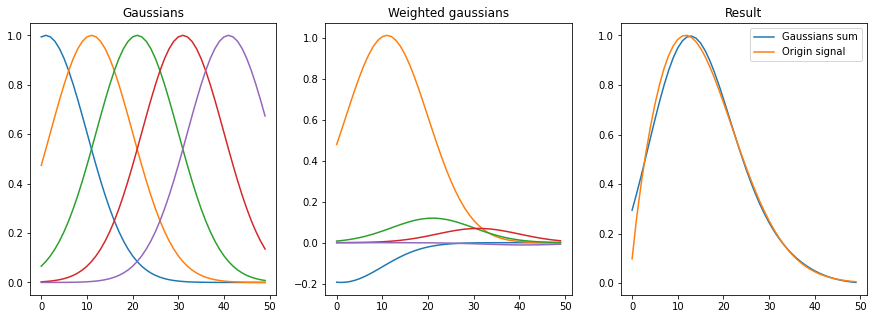

In [3]:
### Parametrization params
GAUSSIAN_STD = 9
COMPRESS_COEF = 10
MODEL = Ridge(alpha=0.1, fit_intercept=False)

gaussian_parametrizer = GaussianParametrizer(COMPRESS_COEF, GAUSSIAN_STD, MODEL)
gaussian_parametrizer.transform_signal(data[0], to_visualize=True)
new_data = gaussian_parametrizer.transform_data(data)

### Generator LSTM

In [4]:
from IPython.display import clear_output

In [5]:
class LstmGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LstmGenerator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.linear(lstm_out)
    
class LstmDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LstmDiscriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        logits = self.linear(lstm_out)
        return self.sigmoid(logits)

### Test Generator

In [8]:
lr=0.005
input_dim = 20
hidden_dim = 30
batch_size = 1

model = LstmGenerator(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tensor(0.0006, grad_fn=<MseLossBackward>)


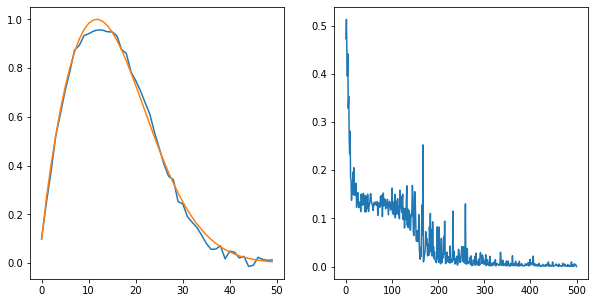

In [9]:
loss_history= []
for it in range(501):
    model.zero_grad()
    z = torch.randn(batch_size, SAMPLE_SIZE, input_dim)
    gen_sample = model(z).squeeze()
    
    loss = criterion(gen_sample, torch.Tensor(data[0]))
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss)
    
    if it % 100 == 0:
        print(loss)
        f, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(gen_sample.detach().numpy())
        ax[0].plot(data[0])
        ax[1].plot(loss_history)
        plt.show()
        clear_output(wait=True)

### GAN

In [7]:
input_dim = 20
hidden_dim = 30
batch_size = 64
data_size = len(new_data[0])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [9]:
G = LstmGenerator(input_dim, hidden_dim).to(device)
D = LstmDiscriminator(1, hidden_dim).to(device)

In [13]:
lr=0.00005
epochs_num = 5000

mse = nn.MSELoss()
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)

In [14]:
dataloader = DataLoader(new_data, batch_size=batch_size, shuffle=True)

In [ ]:
ones_label = Variable(torch.ones(batch_size, 1)).to(device)
zeros_label = Variable(torch.zeros(batch_size, 1)).to(device)
    
for epoch in range(epochs_num):
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

#     z = torch.randn(batch_size, data_size, input_dim).to(device)
#     X = Variable(next(iter(dataloader))).float().to(device)
       

    z = torch.randn(batch_size, 1 + epoch//(epochs_num//data_size), input_dim).to(device)
    X = Variable(next(iter(dataloader))).float().to(device)[:, :z.shape[1]]
    
    G_sample = G(z)
    D_fake = D(G_sample)

    start_loss = mse(G_sample[:, 0, 0], X[:, 0])
    end_loss = mse(G_sample[:, -1, 0], X[:, -1])
    G_loss = F.binary_cross_entropy(D_fake, ones_label) + 5 * (start_loss + end_loss)

    G_loss.backward(retain_graph=True)
    G_optimizer.step()

    # Train discriminator
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

    D_real = D(X[:, :, None])

    D_loss_real = F.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = F.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_optimizer.step()
    
    if epoch % 50 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(epoch, D_loss.cpu().data.numpy(), G_loss.cpu().data.numpy()))

        rows_num = 3
        samples = G(z).squeeze().cpu().data.numpy()[:rows_num**2]
        f, ax = plt.subplots(rows_num, rows_num, figsize=(rows_num**2, rows_num**2))
        for i, sample in enumerate(samples):
            ax[i//rows_num][i % rows_num].plot(new_data[np.random.choice(range(len(new_data)))][:z.shape[1]])
            ax[i//rows_num][i % rows_num].plot(sample)
        plt.show()

### WGAN

Iter-0; D_loss: -7.462501525878906e-05; G_loss: -0.2844356298446655


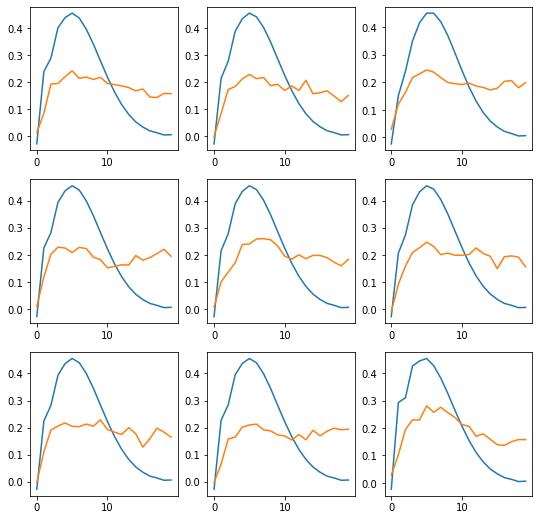

Iter-50; D_loss: -6.946921348571777e-05; G_loss: -0.3826976716518402


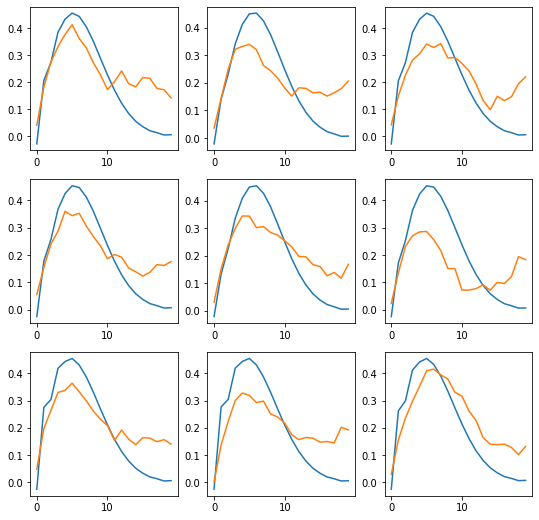

Iter-100; D_loss: -2.9265880584716797e-05; G_loss: -0.46315833926200867


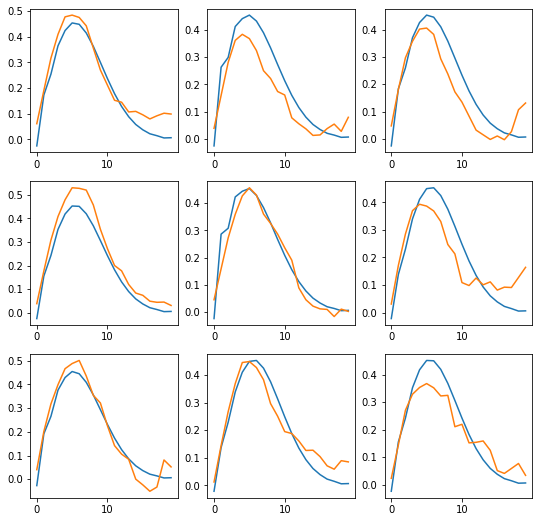

Iter-150; D_loss: -1.0848045349121094e-05; G_loss: -0.47942179441452026


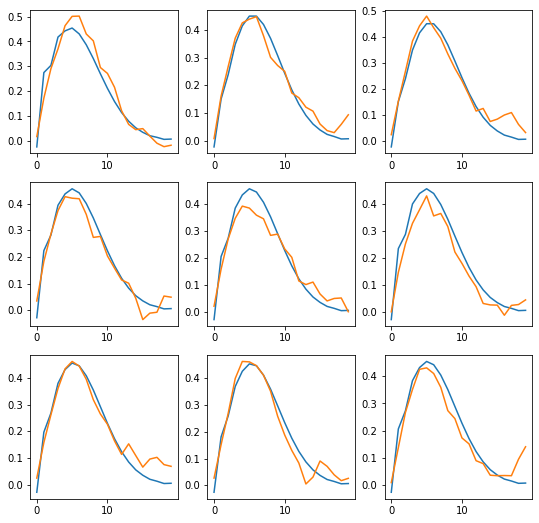

Iter-200; D_loss: -7.510185241699219e-06; G_loss: -0.48282918334007263


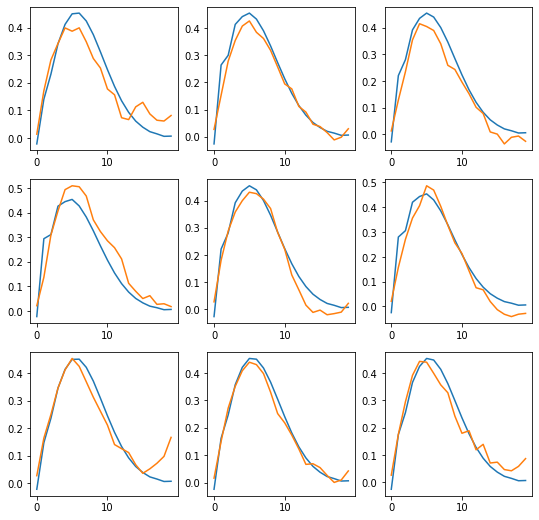

Iter-250; D_loss: -3.2782554626464844e-06; G_loss: -0.48454549908638


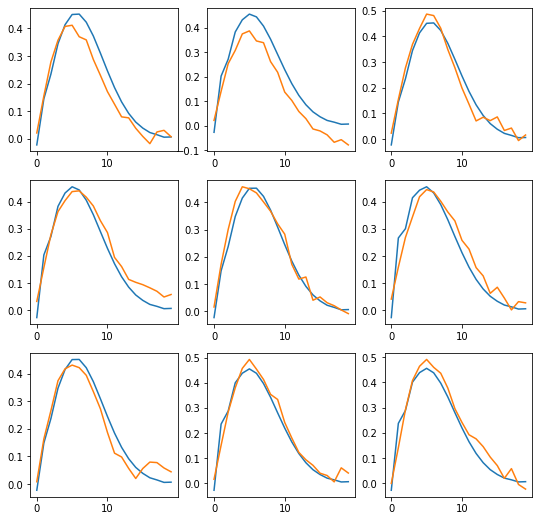

Iter-300; D_loss: -1.0728836059570312e-06; G_loss: -0.4833744764328003


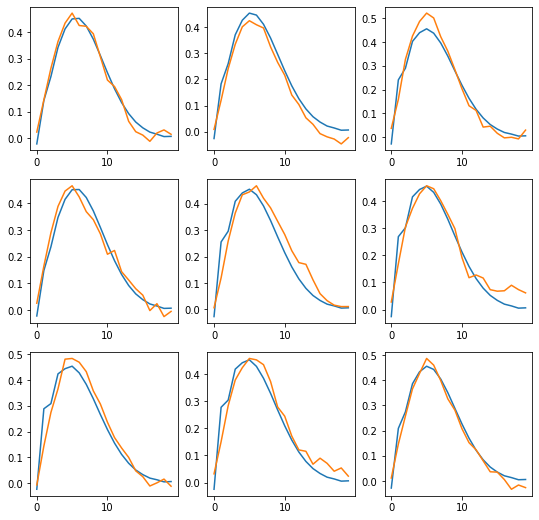

Iter-350; D_loss: -2.384185791015625e-06; G_loss: -0.48744162917137146


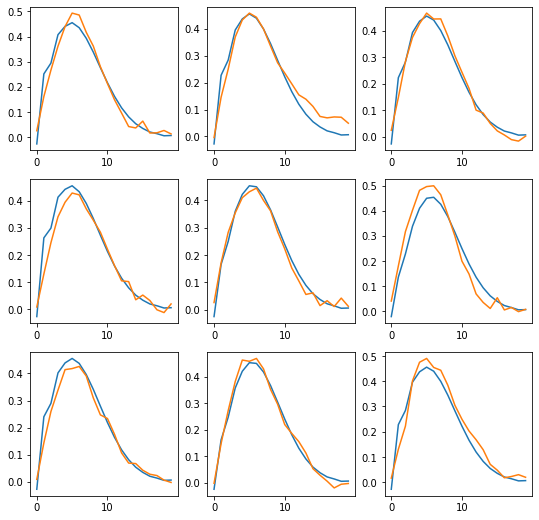

Iter-400; D_loss: -2.086162567138672e-06; G_loss: -0.4881521463394165


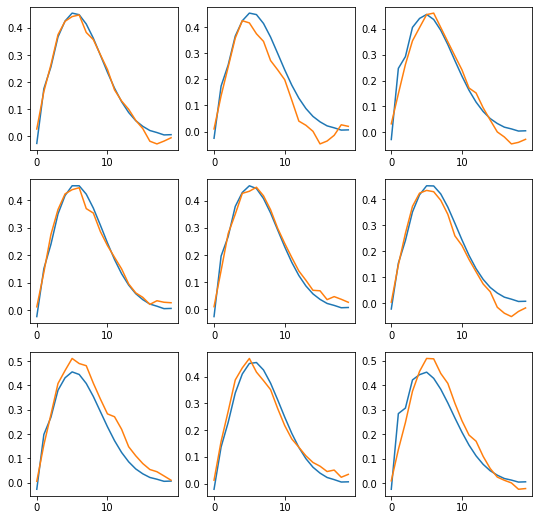

Iter-450; D_loss: -2.682209014892578e-06; G_loss: -0.48991990089416504


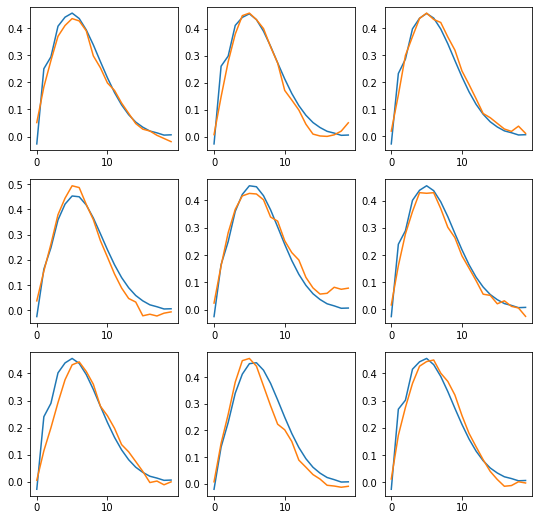

Iter-500; D_loss: 2.0265579223632812e-06; G_loss: -0.48815521597862244


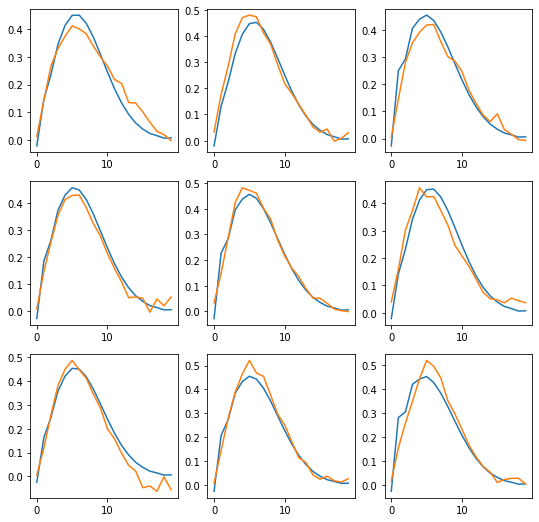

Iter-550; D_loss: -1.0728836059570312e-06; G_loss: -0.4891364276409149


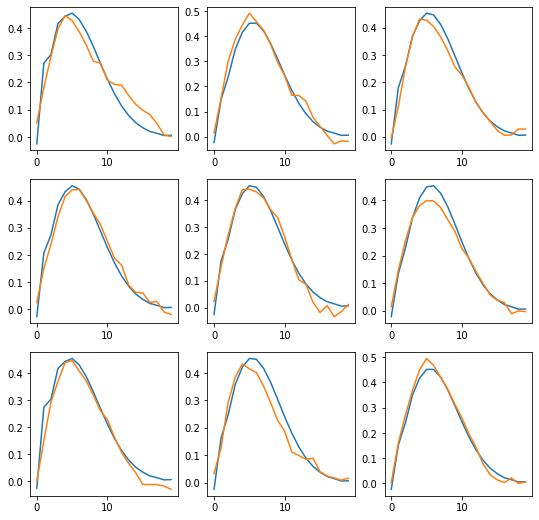

Iter-600; D_loss: -2.086162567138672e-06; G_loss: -0.49000486731529236


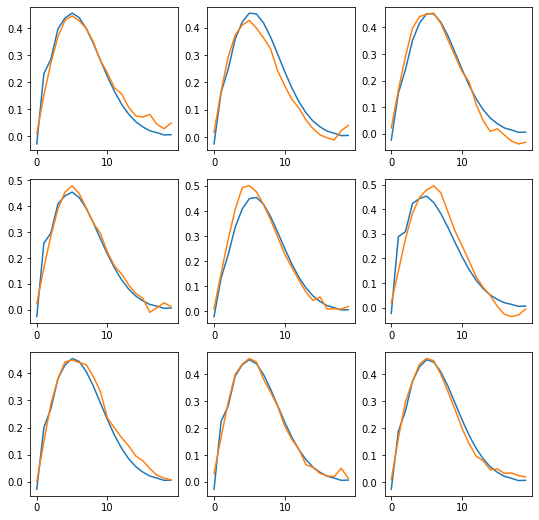

Iter-650; D_loss: -9.5367431640625e-07; G_loss: -0.4894259572029114


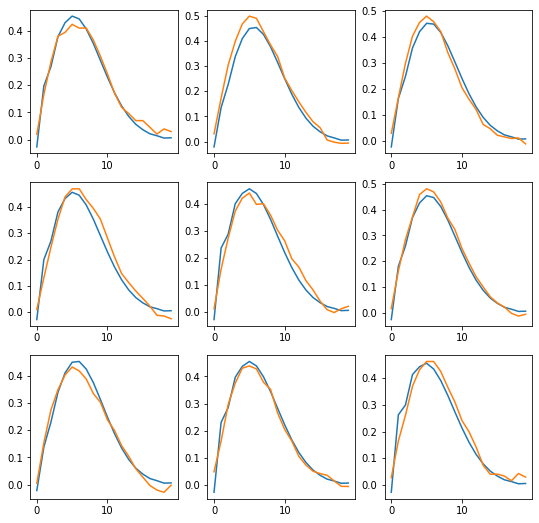

Iter-700; D_loss: -1.2516975402832031e-06; G_loss: -0.4899989068508148


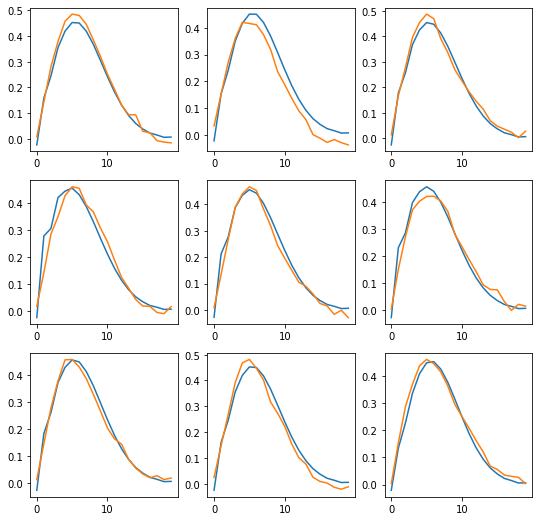

KeyboardInterrupt: 

In [21]:
G_loss_history = []
D_loss_history = []

def reset_grad():
    G.zero_grad()
    D.zero_grad()
    
for epoch in range(epochs_num):
    for _ in range(5):
        # Sample data
#         z = torch.randn(batch_size, 1 + epoch//(epochs_num//data_size), input_dim).to(device)
#         X = Variable(next(iter(dataloader))).float().to(device)[:, :z.shape[1]]

        z = torch.randn(batch_size, data_size, input_dim).to(device)
        X = Variable(next(iter(dataloader))).float().to(device)

        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(X[:, :, None])
        D_fake = D(G_sample)

        start_loss = mse(G_sample.squeeze(), X)
        end_loss = mse(G_sample.squeeze(), X)
        
        D_loss = -(torch.mean(D_real) - torch.mean(D_fake)) #- 1 * (start_loss + end_loss)

        D_loss.backward()
        D_optimizer.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Housekeeping - reset gradient
        reset_grad()


    # Generator forward-loss-backward-update
    z = torch.randn(batch_size, 1 + epoch//(epochs_num//data_size), input_dim).to(device)
    X = Variable(next(iter(dataloader))).float().to(device)[:, :z.shape[1]]
    
    z = torch.randn(batch_size, data_size, input_dim).to(device)
    X = Variable(next(iter(dataloader))).float().to(device)

    G_sample = G(z)
    D_fake = D(G_sample)

    
    start_loss = mse(G_sample.squeeze(), X)
    end_loss = mse(G_sample.squeeze(), X)
    G_loss = -torch.mean(D_fake) + 5 * (start_loss + end_loss)

    G_loss.backward()
    G_optimizer.step()
    
    G_loss_history.append(G_loss)
    D_loss_history.append(D_loss)

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if epoch % 50 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(epoch, D_loss.cpu().data.numpy(), G_loss.cpu().data.numpy()))

        rows_num = 3
        samples = G(z).squeeze().cpu().data.numpy()[:rows_num**2]
        f, ax = plt.subplots(rows_num, rows_num, figsize=(rows_num**2, rows_num**2))
        for i, sample in enumerate(samples):
            ax[i//rows_num][i % rows_num].plot(new_data[np.random.choice(range(len(new_data)))][:z.shape[1]])
            ax[i//rows_num][i % rows_num].plot(sample)
        plt.show()


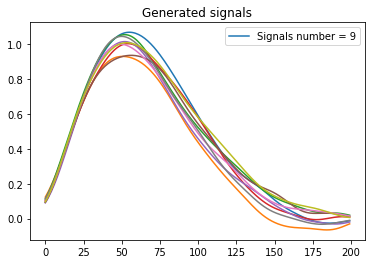

In [22]:
plt.title("Generated signals")
for sample in samples:
    result = [0] * SAMPLE_SIZE
    gaussians = gaussian_parametrizer.gaussians
    for j in range(len(gaussians)):
        result += sample[j] * gaussians[j]
    plt.plot(result)
plt.legend(["Signals number = {}".format(len(samples))])
# plt.plot(data[1])
plt.show()

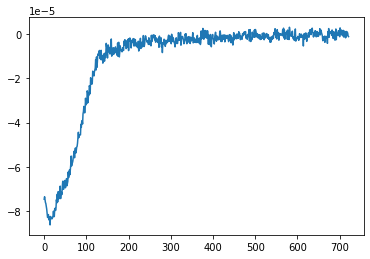

In [23]:
plt.plot(D_loss_history)

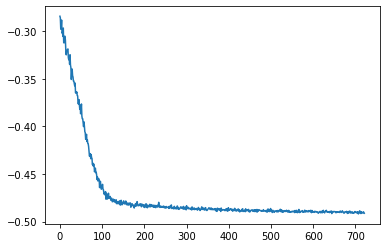

In [24]:
plt.plot(G_loss_history)

In [24]:
G_sample.shape

torch.Size([64, 10, 1])

tensor([0.8282, 0.6835, 0.7456, 0.7301, 0.8089, 0.5190, 0.6437, 0.6085, 0.8708,
        0.6476, 0.6984, 0.7957, 0.5746, 0.5954, 0.8110, 0.5092, 0.6293, 0.8130,
        0.7183, 0.7615, 0.6760, 0.6150, 0.6383, 0.7287, 0.6367, 0.6730, 0.6651,
        0.5991, 0.5843, 0.6076, 0.6639, 0.6419, 0.7127, 0.7148, 0.6728, 0.5927,
        0.6518, 0.5236, 0.6044, 0.5522, 0.6171, 0.6085, 0.6721, 0.6159, 0.8225,
        0.6911, 0.5544, 0.6337, 0.7876, 0.7042, 0.6865, 0.5349, 0.6507, 0.5937,
        0.6724, 0.6880, 0.8148, 0.4813, 0.6977, 0.6863, 0.8073, 0.6015, 0.5716,
        0.8758], device='cuda:0', grad_fn=<SelectBackward>)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [34]:
mse = nn.MSELoss()

In [38]:
torch.sum(G_sample[:, 0, 0])

tensor(42.8165, device='cuda:0', grad_fn=<SumBackward0>)

In [37]:
G_sample[:, 0, 0]

tensor([0.8282, 0.6835, 0.7456, 0.7301, 0.8089, 0.5190, 0.6437, 0.6085, 0.8708,
        0.6476, 0.6984, 0.7957, 0.5746, 0.5954, 0.8110, 0.5092, 0.6293, 0.8130,
        0.7183, 0.7615, 0.6760, 0.6150, 0.6383, 0.7287, 0.6367, 0.6730, 0.6651,
        0.5991, 0.5843, 0.6076, 0.6639, 0.6419, 0.7127, 0.7148, 0.6728, 0.5927,
        0.6518, 0.5236, 0.6044, 0.5522, 0.6171, 0.6085, 0.6721, 0.6159, 0.8225,
        0.6911, 0.5544, 0.6337, 0.7876, 0.7042, 0.6865, 0.5349, 0.6507, 0.5937,
        0.6724, 0.6880, 0.8148, 0.4813, 0.6977, 0.6863, 0.8073, 0.6015, 0.5716,
        0.8758], device='cuda:0', grad_fn=<SelectBackward>)

In [36]:
mse(G_sample[:, 0, 0], torch.zeros(batch_size).to(device))

tensor(0.4558, device='cuda:0', grad_fn=<MseLossBackward>)

In [28]:
.norm()

AttributeError: module 'torch.nn' has no attribute 'norm'